In [63]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [228]:
import numpy as np
import random


class RNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.U = np.random.randn(hidden_dim, input_dim)*0.001
        self.V = np.random.randn(output_dim, hidden_dim)*0.1
        self.W = np.random.randn(hidden_dim, hidden_dim)*0.001
        self.b = np.random.randn(hidden_dim, 1)*0.001
        self.c = np.random.randn(output_dim, 1)*0.1
        
        self.U_last_add = np.zeros(self.U.shape)
        self.V_last_add = np.zeros(self.V.shape)
        self.W_last_add = np.zeros(self.W.shape)
        self.b_last_add = np.zeros(self.b.shape)
        self.c_last_add = np.zeros(self.c.shape)


    def forward(self, x):
        T = x.shape[0]
        self.s = np.zeros((T + 1, self.hidden_dim))
        self.o = np.zeros((T, self.output_dim))
        for i in range(T):
            self.s[i] = np.tanh(np.dot(self.U, x[i]) + np.dot(self.W, self.s[i - 1]) + self.b.T)
            self.o[i] = relu(np.dot(self.V, self.s[i]) + self.c)

    def predict(self, x):
        T = x.shape[0]
        s = np.zeros((self.hidden_dim, 1))
        o = np.zeros((T, self.output_dim))
        for i in range(T):
            s = (np.tanh(np.dot(self.U, x[i]).reshape(self.hidden_dim, 1) + np.dot(self.W, s) + self.b))
            o[i] = relu(np.dot(self.V, s) + self.c)
        return o

    def bptt(self, x, y, learning_rate=0.1):
        T = x.shape[0]
        dLdU = np.zeros(self.U.shape)
        dLdb = np.zeros(self.b.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        dLdc = np.zeros(self.c.shape)
        dLdo = (drelu(self.o[-1]) * (y[-1] - relu(self.o[-1]))).reshape(self.output_dim, 1)
        dLdh = np.dot(self.V.T, dLdo).reshape(self.hidden_dim, 1)

        for t in np.arange(T)[::-1]:
            dLdV += np.dot(dLdo, self.s[t].reshape(1, self.hidden_dim))
            dLdc += dLdo
            dLdW += np.dot(np.dot(np.diag(1 - self.s[t] ** 2), dLdh), self.s[t - 1].reshape(1, self.hidden_dim))
            dLdU += np.dot(np.dot(np.diag(1 - self.s[t] ** 2), dLdh), x[t].reshape(1, self.input_dim))
            dLdb += np.dot(np.diag(1 - self.s[t] ** 2), dLdh)
            # next layer
            dLdo = (drelu(self.o[t - 1]) * (y[t - 1] - relu(self.o[t - 1]))).reshape(self.output_dim, 1)
            dLdh = np.dot(np.dot(self.W.T, np.diag(1 - self.s[t] ** 2)), dLdh) + np.dot(self.V.T, dLdo)

        self.W += learning_rate * (dLdW+0.9*self.W_last_add) / T
        self.U += learning_rate * (dLdU+0.9*self.U_last_add) / T
        self.V += learning_rate * (dLdV+0.9*self.V_last_add) / T
        self.b += learning_rate * (dLdb+0.9*self.b_last_add) / T
        self.c += learning_rate * (dLdc+0.9*self.c_last_add) / T
        
        self.U_last_add = dLdU
        self.V_last_add = dLdV
        self.W_last_add = dLdW
        self.b_last_add = dLdb
        self.c_last_add = dLdc
        

    def emulate(self, x, y):
        return (np.sum((y.reshape(len(y), 1) - self.predict(x)) ** 2) / len(y))

    def emulate_all(self, x, y):
        n = range(len(x))
        error = 0
        for i in n:
            error += self.emulate(x[i], y[i])
        return error

    def fit(self, x, y, learning_rate, epoch=50):
        n = list(range(len(x)))
        for i in range(epoch):
            random.shuffle(n)
            for j in n:
                self.forward(x[j])
                self.bptt(x[j], y[j], learning_rate=learning_rate)
            print(self.emulate_all(x, y))
            print('finish %d epoches' % i)

In [229]:
def relu(x):
    x[x<0] = 0.7*x[x<0]
    return x

def drelu(x):
    a = np.zeros(x.shape)
    a[x>0] = 1
    a[x<0] = 0.7
    return a

def sigmoid(x):
    return 1.0/(1.0+np.exp(x))

def dsigmoid(x):
    return sigmoid(x)*(1.0-sigmoid(x))


In [230]:
#generate data
x = 20
y = []
data = []
for i in range(x):
    sample = np.random.randn(200,20)
    sample = sample[0:np.min(np.argwhere(np.cumsum(np.sum(sample**2,1))>1000))]
    sample = np.column_stack((sample,np.arange(sample.shape[0])))
    data.append(sample)
    y.append(np.arange(sample.shape[0])[::-1])


In [241]:
rnn_phm = RNN(21,100,1)

In [242]:
rnn_phm.fit(data,y,0.001,100)

5656.89829249
finish 0 epoches
5069.3503858
finish 1 epoches
4347.92827033
finish 2 epoches
3481.61651017
finish 3 epoches
2871.71065575
finish 4 epoches
2424.23922095
finish 5 epoches
2026.65435229
finish 6 epoches
2072.30500955
finish 7 epoches
1602.16915512
finish 8 epoches
1429.82773693
finish 9 epoches
1085.52168279
finish 10 epoches
1047.31476903
finish 11 epoches
880.332480271
finish 12 epoches
969.236095234
finish 13 epoches
1123.19504291
finish 14 epoches
1054.0653969
finish 15 epoches
894.921153893
finish 16 epoches
794.106878412
finish 17 epoches
557.365028063
finish 18 epoches
618.354966483
finish 19 epoches
496.884128309
finish 20 epoches
637.160321392
finish 21 epoches
487.090667681
finish 22 epoches
423.61162516
finish 23 epoches
443.854718358
finish 24 epoches
407.710451733
finish 25 epoches
474.176020155
finish 26 epoches
392.443267807
finish 27 epoches
399.92071759
finish 28 epoches
405.689072951
finish 29 epoches
387.788936261
finish 30 epoches
360.838768526
finish 3

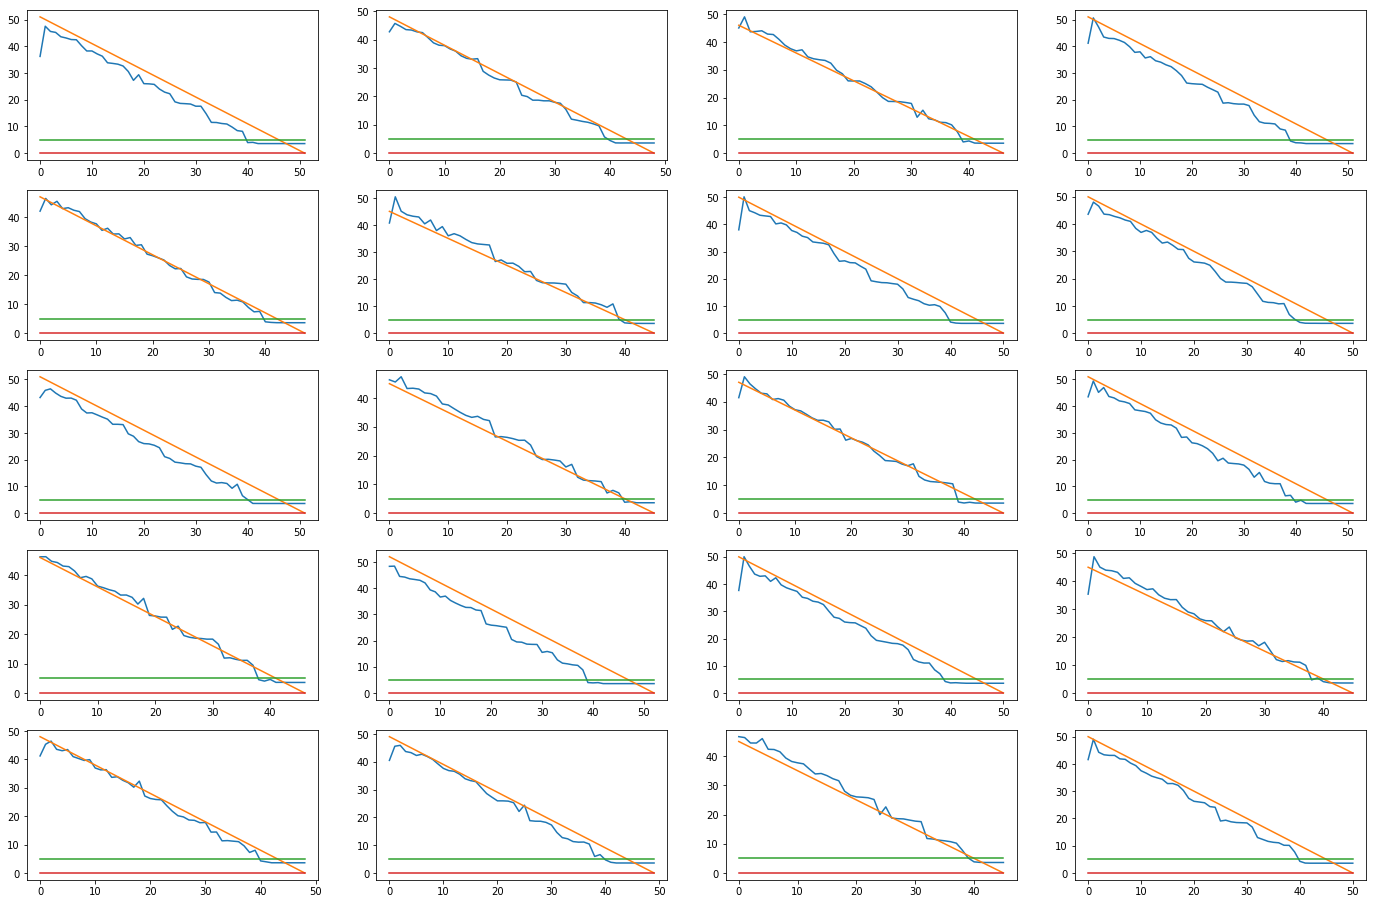

In [244]:
plt.figure(figsize=(24,16))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(rnn_phm.predict(data[i]))
    plt.plot(np.arange(data[i].shape[0])[::-1])
    plt.plot(np.zeros(data[i].shape[0])+5)
    plt.plot(np.zeros(data[i].shape[0]))
plt.show()

In [245]:
#generate test data
x = 20
y_test = []
data_test = []
for i in range(x):
    sample = np.random.randn(200,20)
    sample = sample[0:np.min(np.argwhere(np.cumsum(np.sum(sample**2,1))>1000))]
    sample = np.column_stack((sample,np.arange(sample.shape[0])))
    data_test.append(sample)
    y_test.append(np.arange(sample.shape[0])[::-1])

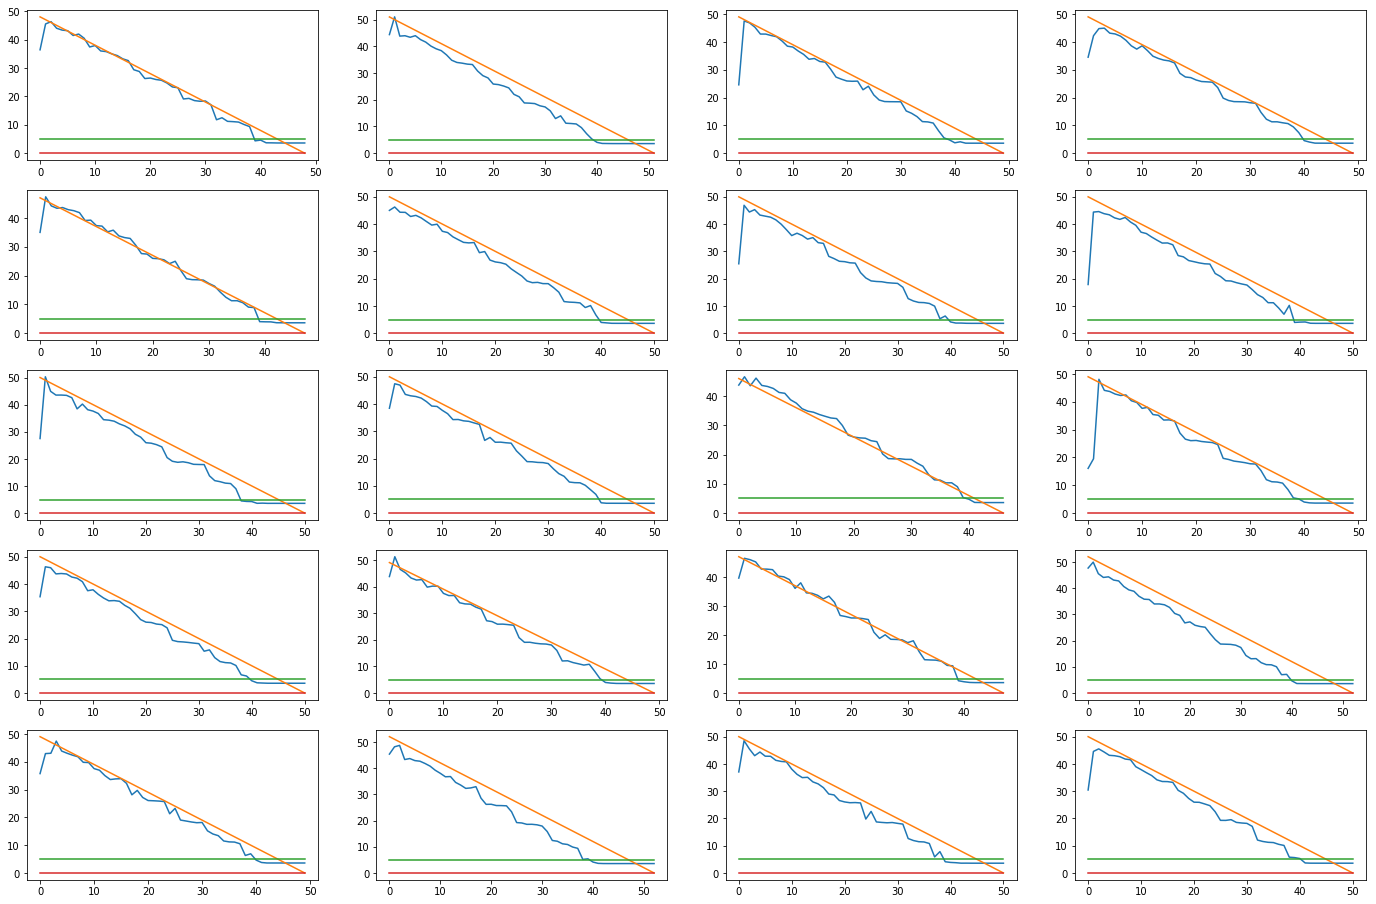

In [246]:
plt.figure(figsize=(24,16))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(rnn_phm.predict(data_test[i]))
    plt.plot(np.arange(data_test[i].shape[0])[::-1])
    plt.plot(np.zeros(data_test[i].shape[0])+5)
    plt.plot(np.zeros(data_test[i].shape[0]))
plt.show()

In [227]:
T = data[1].shape[0]
s = np.zeros((60, 1))
o = np.zeros((T, 1))
for i in range(T):
    s = (np.tanh(np.dot(rnn_phm.U, data[1][i]).reshape(60, 1) + np.dot(rnn_phm.W, s) + rnn_phm.b))
    print(s)
    o[i] = relu(np.dot(rnn_phm.V, s) + rnn_phm.c)
    print(o[i])

[[-0.94096049]
 [ 0.86883202]
 [-0.89679317]
 [ 0.77483992]
 [-0.96741983]
 [ 0.96796315]
 [-0.68901922]
 [ 0.97546172]
 [ 0.99323734]
 [-0.96359217]
 [-0.92306018]
 [-0.94751515]
 [ 0.81902262]
 [-0.92064034]
 [-0.93840204]
 [ 0.89064822]
 [ 0.94675251]
 [ 0.99141265]
 [ 0.93366827]
 [-0.9595851 ]
 [ 0.99999636]
 [ 0.93008181]
 [-0.95540361]
 [-0.37309758]
 [-0.3843648 ]
 [ 0.87606356]
 [ 0.11727824]
 [-0.93532526]
 [-0.3348648 ]
 [-0.24816762]
 [ 0.39636038]
 [-0.68940054]
 [ 0.77478822]
 [-0.91502143]
 [-0.36529803]
 [-0.78466613]
 [ 0.87678642]
 [ 0.98346472]
 [ 0.97056501]
 [ 0.95405249]
 [ 0.95820492]
 [ 0.69043278]
 [ 0.64687776]
 [-0.95573916]
 [ 0.9269943 ]
 [ 0.97139617]
 [ 0.97869208]
 [-0.29357556]
 [-0.82442421]
 [ 0.62275079]
 [ 0.86018913]
 [ 0.97750572]
 [-0.55841509]
 [ 0.81655322]
 [-0.95558735]
 [-0.90727674]
 [ 0.96246238]
 [-0.94652777]
 [ 0.99094893]
 [-0.94214808]]
[ 43.80533205]
[[-0.99960828]
 [ 0.99846604]
 [-0.99910646]
 [ 0.99656368]
 [-0.99977876]
 [ 0.9998

In [48]:
rnn_phm.U.shape

(50, 21)